# IBM Data Science Professional Certificate - Capstone Project 

## 1. Introduction

In this notebook, I will be using Python and Machine Learning to analyse and segment Canadian Ski Resorts. I thought it would be interesting to locate different resorts, then use the Foursquare API to analyse bars, hotels and restaurants in the area to segment resorts.

Both Resort Managers and skiers would be able to view resorts and their respective clusters, and make decisions. 

![Ski Prices](https://www.mountainwatch.com/wp-content/uploads/2018/11/3.png)

### 1.1 Background

The demand for snowsports is at an all time high. More people than ever are skiing, snowboarding and exploring the wonderful world of winter sports. However, the cost of a ski holiday has also majorly increased. People are paying more for their holidays, and as such, demand the best possible experience. 

As we can see above, the total cost of a ski holiday at Vail could set you back on average over $3200. 

So, ski resorts must cater to this increased demand and deliver quality. 

### 1.2 Problem

With the added pressure of climate change on the amount of snow, ski resorts are trying to improve customer experience within resorts. In addition to skiing, they are offering a range of other activities and facilities. 

Their ultimate goals are to :
1. Attract as many tourists as possible through targeted marketing
2. Enhance customer experience
3. Increase the revenue per customer within the resort

Therefore, ski resort managers are looking to enhance customer experience, improve their marketing whilst minimising costs. This is the problem we are trying to solve using clustering. If resorts can identify their niche, or relevant competitors, they can gain insights into their marketable strengths or use ideas from similar resorts. 

## 2. Data

The data I will be using is a combination of the Foursquare API, and the OpenStreetMap ski resort data. 

### 2.2 Data Gathering

Data will be gathered firstly from OpenSkiMap, which gives the names and regions of each ski resort. Restricting this to Canada, we can then view the data for Canadian Ski Resorts and the type of skiing. 

This will then be geolocated, and then combined with relevant venue data from Foursquare API. This will demonstrate the types of venues surrounding our ski resorts. 

### 2.2 Solving the Problem

With our ski resort and venue data, we are able to categorise resorts based on the amenities they offer to guests. This will allow us to cluster and segment resorts, so resort managers can compare their resport with similar resorts to understand potential revenue building strategies, and more finely tune their marketing based on their target market.

## 3. Methodology

### 3.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import geocoder
import folium
from sklearn.cluster import KMeans


In [2]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [3]:
from IPython.display import display

In [4]:
import requests
from pandas.io.json import json_normalize
import urllib
import json

In [5]:
print("Libraries loaded!")

Libraries loaded!


### 3.2 Importing and Loading Data

In [6]:
url = 'http://tiles.skimap.org/geojson/ski_areas.geojson'
jsonurl = urllib.request.urlopen(url)
ski_area = json.loads(jsonurl.read())

In [7]:
ski_area = ski_area['features']

Now, I am creating an empty dataframe to hold the ski resort data. 

In [8]:
column_names  = ['country','region','locality','name']

In [9]:
ski_data =  pd.DataFrame(columns=column_names)
ski_data

,country,region,locality,name


Then, let's loop through the JSON file and add to our pandas dataframe. 

In [10]:
for data in ski_area:
    try:
        type = data['properties']['activities']
        country = data['properties']['location']['localized']['en']['country']
        region = data['properties']['location']['localized']['en']['region']
        locality = data['properties']['location']['localized']['en']['locality']
        name = data['properties']['name']
    except:
        pass
    
    ski_data = ski_data.append({'type': type,
                               'country': country,
                               'region': region,
                               'locality': locality,
                               'name': name}, ignore_index=True)

In [11]:
ski_data.head()

,country,region,locality,name,type
0,Slovenia,None,Vuhred,None,[downhill]
1,Germany,Rhineland-Palatinate,Hohenleimbach,None,[downhill]
2,Spain,Castile and León,Espinosa de los Monteros,Estación de Esquí Lunada,[downhill]
3,Norway,None,Voss herad,Haugsåsen (Granvin Alpin),[downhill]
4,Norway,None,Vartdal,None,[downhill]


Now, we have a dataframe with the information for ski resorts around the world. However, I am focusing on Canada. 

In [12]:
ski_data = ski_data[ski_data['country'] == 'Canada']
ski_data.reset_index(inplace = True)
print(ski_data.shape)
ski_data.head()

(600, 6)


,index,country,region,locality,name,type
0,200,Canada,Quebec,Laval,Bois Duvernay,[nordic]
1,201,Canada,None,Mansfield-et-Pontefract,Mont Chilly,[downhill]
2,210,Canada,Quebec,Val-David,Parc régional de Val-David - Val-Morin,[nordic]
3,347,Canada,None,None,None,[downhill]
4,794,Canada,Alberta,None,None,[nordic]


As we can see, there are a total of 603 ski areas identified in Canada. That's a lot! Perhaps we should check for duplicates, and clean the data. 

In [13]:
ski_data.drop(['index', 'country'], axis = 1, inplace = True)

In [14]:
ski_data.rename(columns = {'name': 'resort'}, inplace = True)

In [15]:
ski_data.drop_duplicates(subset='resort', inplace = True)

In [16]:
ski_data['ski type'] = ski_data['type'].apply(', '.join)
ski_data['ski type'] = ski_data['ski type'].str.replace('nordic, downhill', 'downhill, nordic')
ski_data.drop('type', axis = 1,inplace=True)

In [17]:
ski_data['ski type'].value_counts()

downhill            269
nordic               79
downhill, nordic     53
                     22
Name: ski type, dtype: int64

In [18]:
print(ski_data.shape)
ski_data.reset_index(inplace = True)
ski_data.drop('index', axis = 1, inplace = True)
ski_data.head()

(423, 4)


,region,locality,resort,ski type
0,Quebec,Laval,Bois Duvernay,nordic
1,None,Mansfield-et-Pontefract,Mont Chilly,downhill
2,Quebec,Val-David,Parc régional de Val-David - Val-Morin,nordic
3,None,None,None,downhill
4,Saskatchewan,None,Prairie West Terminal Snow Park (Twin Towers),downhill


### 3.3 Visualising Data

Now, we have cleaned the data. Let's visualise the data:

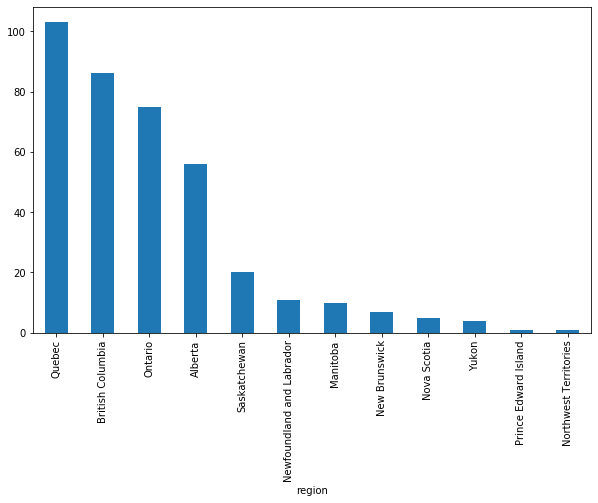

In [19]:
ski_counts = ski_data.groupby('region').count()['resort']
ski_counts = ski_counts.sort_values(ascending = False)

ski_counts.plot(kind='bar', figsize=(10,6))
plt.show()

According to the chart above, Quebec has the largest number of resorts, closely followed by British Columbia. 

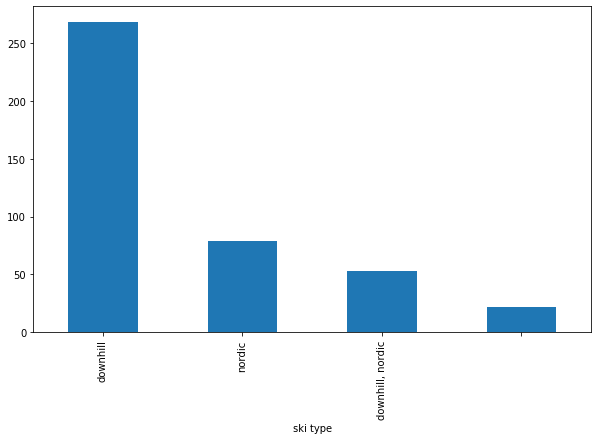

In [20]:
type_counts = ski_data.groupby('ski type').count()['resort']
type_counts = type_counts.sort_values(ascending = False)

type_counts.plot(kind='bar', figsize=(10,6))
plt.show()

Looks like the majority of areas are for downhill skiing, however there are some that are just nordic skiing, and others that have no tag. 

I am concentrating on downhill skiing here, so will drop the resorts with no tag. 

### 3.4 Geocoding Data

In [21]:
Latitude = []
Longitude = []

lat_lng_coords = None


for i in ski_data['locality']:
    g = geocoder.arcgis('{}, Canada'.format(i))
    lat_lng_coords = g.latlng
    
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    Latitude.append(latitude)
    Longitude.append(longitude)

In [22]:
ski_data['latitude'] = Latitude
ski_data['longitude'] = Longitude
ski_data.head()

,region,locality,resort,ski type,latitude,longitude
0,Quebec,Laval,Bois Duvernay,nordic,45.55201,-73.74433
1,None,Mansfield-et-Pontefract,Mont Chilly,downhill,45.84979,-76.72708
2,Quebec,Val-David,Parc régional de Val-David - Val-Morin,nordic,46.03258,-74.20374
3,None,None,None,downhill,60.10867,-113.64258
4,Saskatchewan,None,Prairie West Terminal Snow Park (Twin Towers),downhill,60.10867,-113.64258


### 3.5 Creating a Map

In [23]:
latitude_can = 56.1304
longitude_can = -106.3468

map_canada = folium.Map(location=[latitude_can, longitude_can], zoom_start = 4)

# adding map markers
for lat, lng, province, resort in zip(ski_data['latitude'], ski_data['longitude'], ski_data['region'], ski_data['resort']):
    label = '{}, {}'.format(resort, province)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color = '#3186CC',
    fill_opacity = 0.7,
    parse_html = False).add_to(map_canada)
    
map_canada

### 3.6 Gathering Venue Data - *Foursquare API*

#### Define Foursquare credientials and version

In [24]:
CLIENT_ID = 'QZILF53ALV5FZK2M2HPSCTIY13G3ULWCWW5B5O1ZNMRZRX4P' # your Foursquare ID
CLIENT_SECRET = '534KHDW3Z24250C0HZ23R2Z0QNYMNQ5VNAH5RQNBNTEIK4XB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QZILF53ALV5FZK2M2HPSCTIY13G3ULWCWW5B5O1ZNMRZRX4P
CLIENT_SECRET:534KHDW3Z24250C0HZ23R2Z0QNYMNQ5VNAH5RQNBNTEIK4XB


#### Explore a resort in our dataset

In [25]:
ski_data.loc[50, 'resort']

'Apex Mountain Resort'

In [26]:
resort_latitude = ski_data.loc[50, 'latitude']
resort_longitude = ski_data.loc[50, 'longitude']
resort_name = ski_data.loc[50, 'resort']

print('Latitude and longitude values of {} are {}, {}.'.format(resort_name, 
                                                               resort_latitude, 
                                                               resort_longitude))

Latitude and longitude values of Apex Mountain Resort are 49.39267000000007, -119.60213999999996.


In [27]:
radius = 2000


url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    resort_latitude, 
    resort_longitude, 
    VERSION, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=QZILF53ALV5FZK2M2HPSCTIY13G3ULWCWW5B5O1ZNMRZRX4P&client_secret=534KHDW3Z24250C0HZ23R2Z0QNYMNQ5VNAH5RQNBNTEIK4XB&ll=49.39267000000007,-119.60213999999996&v=20180605&radius=2000&limit=100'

In [28]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fecca93ba6fa474b881e48a'},
 'response': {'headerLocation': 'Kaleden',
  'headerFullLocation': 'Kaleden',
  'headerLocationGranularity': 'city',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 49.41067001800008,
    'lng': -119.57453637299251},
   'sw': {'lat': 49.37466998200005, 'lng': -119.62974362700741}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8673f8d66a9b178e9114fe',
       'name': 'Petro-Canada',
       'location': {'address': '210 Hwy. 97 S.',
        'lat': 49.395862223239945,
        'lng': -119.60556402662252,
        'labeledLatLngs': [{'label': 'display',
          'lat': 49.395862223239945,
          'lng': -119.60556402662252}],
        'distance': 433,
        'postalCode': 'V0H 1K0',
        'cc': '

In [29]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\Caitlin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Petro-Canada,Gas Station,49.395862,-119.605564
1,Rama Fruit Market and U-Pick,Fruit & Vegetable Store,49.401430,-119.605779
2,Linden Gardens,Garden,49.384950,-119.588896
3,Skaha Lake,Lake,49.383497,-119.578601


In [31]:
print("There were {} venues returned by Foursquare".format(nearby_venues.shape[0]))

There were 4 venues returned by Foursquare


### 3.7 Explore All Canadian Ski Resorts

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['resort', 
                  'resort latitude', 
                  'resort longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

In [33]:
resort_venues = getNearbyVenues(ski_data['resort'], ski_data['latitude'], ski_data['longitude'])
resort_venues

Bois Duvernay
Mont Chilly
Parc régional de Val-David - Val-Morin
None
Prairie West Terminal Snow Park (Twin Towers)
Northern Lights Ski Club
Falcon Ridge
Stony Mountain Ski Area
Crystal Mountain Resort
Mystery Mountain
Summit Lake
Mont Shefford
Smokey Mountain Ski Club
Kinosoo Ridge
Canyon Ski Resort (Ski Red Deer)
Mission Ridge Winter Park
Gray Rocks
Salmo Ski Area
White Hills
Snow Valley Ski Club
Brookvale Provincial Park
Sunridge Ski Area
Holiday Mountain
Table Mountain
Hidden Valley
Nitehawk Ski Hill
Sugarloaf Provincial Park
Purden Ski Village
Wapiti Valley
Phoenix Mountain
Tabor Mountain
Rabbit Hill Ski and Snowboard Center
Mont Orignal
Asessippi Ski Area and Resort
Marble Mountain
Murray Ridge
Shames Mountain
Marmot Basin
Mont Farlagne
Hudson Bay Mountain (Ski Smithers)
Powder King
Mount Norquay
Ski Wentworth
Nakiska Ski Resort
Mt. Baldy Family Ski Area
Kimberley Alpine Resort
Fortress (Snowridge)
Manning Park Resort
Fernie Alpine Resort
Ski Bromont
Apex Mountain Resort
Mont Alt

Castle Mountain Resort
Clearwater
Misery Mountain
Mont Garceau
Dakota Ridge
Mont Cascades
Mont Avila
Belle Neige
Mont Blanc
Sasquatch Mountain (Hemlock Resort)
Val Saint-Come
Whistler Blackcomb (Garibaldi Lift Co.)
Beaver Valley
Gatineau Park
Do-mi-ski
Mont Pits (Centre De Cabano)
The ROC


,resort,resort latitude,resort longitude,venue,venue latitude,venue longitude,venue category
0,Bois Duvernay,45.55201,-73.74433,Beroya,45.555693,-73.752050,Middle Eastern Restaurant
1,Bois Duvernay,45.55201,-73.74433,Marché Tau,45.556879,-73.746872,Health Food Store
2,Bois Duvernay,45.55201,-73.74433,Toyo Grillades À La Japonaise,45.552203,-73.747151,Japanese Restaurant
3,Bois Duvernay,45.55201,-73.74433,Première Moisson,45.564399,-73.744262,Bakery
4,Bois Duvernay,45.55201,-73.74433,Indigo,45.555592,-73.727551,Bookstore
...,...,...,...,...,...,...,...
6935,The ROC,44.30113,-79.43959,Lake Simcoe,44.309932,-79.451191,Lake
6936,The ROC,44.30113,-79.43959,Georgina Civic Centre Soccer Field,44.298219,-79.436470,Soccer Field
6937,The ROC,44.30113,-79.43959,The ROC,44.293322,-79.436322,Mountain
6938,The ROC,44.30113,-79.43959,Willow Beach Park,44.311778,-79.423028,Park


In [34]:
print(resort_venues.shape)
#resort_venues.rename({'Neighborhood': 'resort', 'Neighborhood Latitude': 'latitude', 'Neighborhood Longitude': 'resort longitude'}, axis=1, inplace = True)
resort_venues.head()

(6940, 7)


,resort,resort latitude,resort longitude,venue,venue latitude,venue longitude,venue category
0,Bois Duvernay,45.55201,-73.74433,Beroya,45.555693,-73.752050,Middle Eastern Restaurant
1,Bois Duvernay,45.55201,-73.74433,Marché Tau,45.556879,-73.746872,Health Food Store
2,Bois Duvernay,45.55201,-73.74433,Toyo Grillades À La Japonaise,45.552203,-73.747151,Japanese Restaurant
3,Bois Duvernay,45.55201,-73.74433,Première Moisson,45.564399,-73.744262,Bakery
4,Bois Duvernay,45.55201,-73.74433,Indigo,45.555592,-73.727551,Bookstore


In [35]:
print("There are {} types of venue".format(len(resort_venues['venue category'].unique())))

There are 306 types of venue


### 3.8 Analysing Resort Venues

In [36]:
# one hot encoding
ski_onehot = pd.get_dummies(resort_venues[['venue category']], prefix= "", prefix_sep = "")

# add resort column back to dataframe
ski_onehot['resort'] = resort_venues['resort']

# move resort to first column
fixed_columns = [ski_onehot.columns[-1]] + list(ski_onehot.columns[:-1])
ski_onehot = ski_onehot[fixed_columns]
ski_onehot.head()

,resort,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Water Park,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Bois Duvernay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bois Duvernay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bois Duvernay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bois Duvernay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bois Duvernay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
ski_onehot.shape

(6940, 307)

In [38]:
ski_grouped = ski_onehot.groupby('resort').mean().reset_index()
ski_grouped.head(10)

,resort,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Water Park,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,108 Mile House,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0
1,99 Mile Ski Trails,0.0,0.0,0.0,0.0,0.153846,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0
2,AE Wilson Park cross country ski trails,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.01087,0.0,0.0,0.00,0.010870,0.00,0.000000,0.0,0.0,0.0
3,Adanac Ski HIll,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0
4,Airport Nordic Ski Club Cross Country Ski Trails,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.000000,0.00,0.058824,0.0,0.0,0.0
5,Alice Hill Park (Pembroke Ski Club),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0
6,Allison-Chinook Cross Country Ski Trails (Crow...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0
7,Alpine Ski Club,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.066667,0.00,0.000000,0.0,0.0,0.0
8,Apex Mountain Resort,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0,0.0
9,Argyll Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.01000,0.0,0.0,0.01,0.000000,0.01,0.000000,0.0,0.0,0.0


In [39]:
ski_grouped.shape

(379, 307)

Let's put our data into a pandas dataframe

In [40]:
# sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['resort']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
resort_venues_sorted = pd.DataFrame(columns=columns)
resort_venues_sorted['resort'] = ski_grouped['resort']

for ind in np.arange(ski_grouped.shape[0]):
    resort_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ski_grouped.iloc[ind, :], num_top_venues)

resort_venues_sorted.head()

,resort,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,108 Mile House,Construction & Landscaping,Rest Area,Fishing Spot,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
1,99 Mile Ski Trails,American Restaurant,Gas Station,Ice Cream Shop,Grocery Store,Coffee Shop,Sandwich Place,Fast Food Restaurant,Café,Supermarket,Breakfast Spot
2,AE Wilson Park cross country ski trails,Coffee Shop,Café,Restaurant,Sandwich Place,Grocery Store,Thai Restaurant,Hotel,Pharmacy,Indian Restaurant,Pizza Place
3,Adanac Ski HIll,Flower Shop,Business Service,Event Service,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Zoo
4,Airport Nordic Ski Club Cross Country Ski Trails,Fast Food Restaurant,Auto Workshop,Coffee Shop,Stadium,History Museum,Motel,Furniture / Home Store,Grocery Store,Sandwich Place,Pharmacy


### 3.9 Clustering Resorts

Run k-means to split resorts into different clusters. We will begin by running the Elbow Method to determine the optimal number of clusters, then run the full model and create a map to illustrate.

#### Using Elbow Method to Determine Optimum Value of K 

In [64]:
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
resort_grouped_clustering = ski_grouped.drop('resort', 1)

In [58]:
X = resort_grouped_clustering
X = np.nan_to_num(X)
X[:10]

# X = resort_grouped_clustering[:,'']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

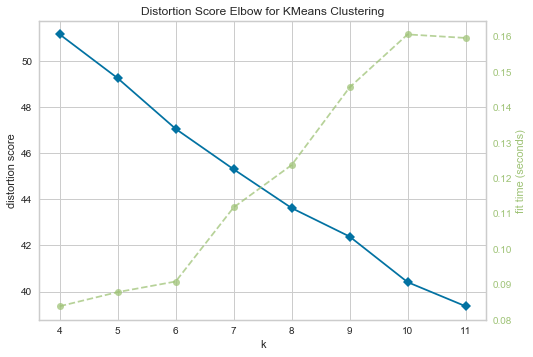

C:\Users\Caitlin\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001EF69AA6808>,
                 k=None, locate_elbow=False, metric='distortion', model=None,
                 timings=True)

In [62]:
# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=4), X, k=(4,12), locate_elbow=False)

As we can see above, there is no optimal elbow point. Let's try with another metric, calinski harabasz.

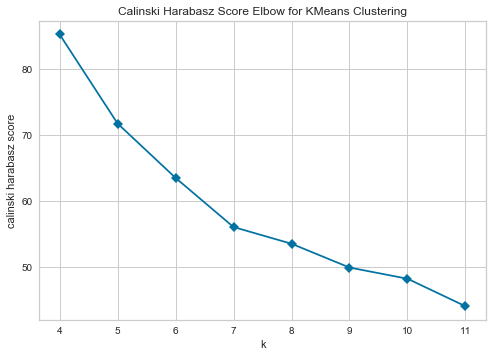

In [65]:
# Try with calinski harabasz

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False, locate_elbow=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

It is important to remember that the “elbow” method does not work well if the data is not very clustered. In this case, you might see a smooth curve and the optimal value of of K is therefore unclear.

As K is unclear, we will set the number to 5. This is because we are using the top-10 venues, and having this number of attributes lends itself well to a K of 5. 

#### Running K-Means Clustering

In [42]:
# set number of clusters
k_clusters = 5

#run k-means
kmeans = KMeans(n_clusters = k_clusters, random_state = 0).fit(resort_grouped_clustering)

# check cluster labels
kmeans.labels_[0:10]

array([4, 3, 3, 1, 3, 1, 1, 3, 3, 3])

Creating a new dataframe that includes the cluster as well as the top-10 venues for each resort.

In [43]:
resort_venues_sorted.insert(0, 'cluster labels', kmeans.labels_)
ski_merged = ski_data

# merge to add long/latfor each neighbourhood
ski_merged = ski_merged.join(resort_venues_sorted.set_index('resort'), on='resort')
ski_merged.head()

,region,locality,resort,ski type,latitude,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Quebec,Laval,Bois Duvernay,nordic,45.55201,-73.74433,3.0,Breakfast Spot,Grocery Store,Greek Restaurant,Italian Restaurant,Coffee Shop,Liquor Store,Supermarket,Sushi Restaurant,French Restaurant,Department Store
1,None,Mansfield-et-Pontefract,Mont Chilly,downhill,45.84979,-76.72708,3.0,Motel,Historic Site,Construction & Landscaping,Hotel Bar,Supermarket,Diner,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
2,Quebec,Val-David,Parc régional de Val-David - Val-Morin,nordic,46.03258,-74.20374,3.0,Coffee Shop,Café,Ice Cream Shop,Supermarket,Ski Area,Bar,Trail,Playground,Thrift / Vintage Store,Hotel
3,None,None,None,downhill,60.10867,-113.64258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Saskatchewan,None,Prairie West Terminal Snow Park (Twin Towers),downhill,60.10867,-113.64258,1.0,Flower Shop,Business Service,Event Service,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Zoo


In [44]:
ski_merged.dropna(inplace=True)
ski_merged.shape

(287, 17)

In [45]:
ski_merged.head(10)

,region,locality,resort,ski type,latitude,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Quebec,Laval,Bois Duvernay,nordic,45.55201,-73.74433,3.0,Breakfast Spot,Grocery Store,Greek Restaurant,Italian Restaurant,Coffee Shop,Liquor Store,Supermarket,Sushi Restaurant,French Restaurant,Department Store
2,Quebec,Val-David,Parc régional de Val-David - Val-Morin,nordic,46.03258,-74.20374,3.0,Coffee Shop,Café,Ice Cream Shop,Supermarket,Ski Area,Bar,Trail,Playground,Thrift / Vintage Store,Hotel
5,Newfoundland and Labrador,Churchill Falls,Northern Lights Ski Club,downhill,53.53036,-64.00152,0.0,Restaurant,Zoo,Fishing Spot,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
7,Manitoba,Stony Mountain,Stony Mountain Ski Area,downhill,50.08592,-97.21851,3.0,Construction & Landscaping,Food Service,Auto Workshop,Bar,Ski Chalet,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
10,British Columbia,Area H (The Slocan Valley),Summit Lake,downhill,49.76245,-117.46289,0.0,Restaurant,Lake,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
11,Quebec,Shefford,Mont Shefford,downhill,45.34535,-72.57409,4.0,Construction & Landscaping,Trail,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
12,Newfoundland and Labrador,Labrador City,Smokey Mountain Ski Club,downhill,52.95005,-66.91454,3.0,Sandwich Place,Big Box Store,Fast Food Restaurant,Shopping Mall,Coffee Shop,Gas Station,Grocery Store,Farm,Farmers Market,Field
15,Saskatchewan,Fort Qu'Appelle,Mission Ridge Winter Park,downhill,50.76356,-103.79635,3.0,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Gas Station,Coffee Shop,Fishing Spot,Farmers Market,Field,Filipino Restaurant,Fish & Chips Shop
16,Quebec,Mont-Tremblant,Gray Rocks,downhill,46.20608,-74.58519,3.0,Hotel,Ski Chairlift,American Restaurant,Resort,Restaurant,Dessert Shop,Ice Cream Shop,Coffee Shop,French Restaurant,Pizza Place
18,Newfoundland and Labrador,Clarenville,White Hills,downhill,48.14813,-53.96935,3.0,Coffee Shop,Grocery Store,Hotel,Juice Bar,Fishing Spot,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


In [46]:
ski_merged['cluster labels'].value_counts()

3.0    253
4.0     14
0.0     10
2.0      7
1.0      3
Name: cluster labels, dtype: int64

#### Map clusters

In [47]:
# create map
map_clusters = folium.Map(location=[latitude_can, longitude_can], zoom_start=4)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ski_merged['latitude'], ski_merged['longitude'], ski_merged['resort'], ski_merged['cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4. Results

Now, let's examine each cluster and see the properties.

#### Cluster 1

In [48]:
ski_merged.loc[ski_merged['cluster labels'] == 0, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]

,locality,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Churchill Falls,-64.00152,0.0,Restaurant,Zoo,Fishing Spot,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
10,Area H (The Slocan Valley),-117.46289,0.0,Restaurant,Lake,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
113,Bolton-Ouest,-72.46586,0.0,Lake,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop
138,Area D (Elaho/Garibaldi),-123.14613,0.0,Lake,Ski Area,Zoo,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
139,Area D (Elaho/Garibaldi),-123.14613,0.0,Lake,Ski Area,Zoo,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
156,Saint-Aimé-du-Lac-des-Îles,-75.51196,0.0,Liquor Store,Lake,Zoo,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
301,Harrington,-74.54768,0.0,Liquor Store,Pub,Lake,Zoo,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
311,Chapleau Township,-83.40490,0.0,Restaurant,Motel,Zoo,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
315,Notre-Dame-de-la-Salette,-75.58332,0.0,Restaurant,Construction & Landscaping,Park,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
332,Area H (The Slocan Valley),-117.46289,0.0,Restaurant,Lake,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market


In [49]:
ski_merged.loc[ski_merged['cluster labels'] == 0, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]['1st Most Common Venue'].value_counts()

Restaurant      5
Lake            3
Liquor Store    2
Name: 1st Most Common Venue, dtype: int64

All of these boast restaurants, lakes or liquor stores. They are most likely day-use ski resorts.

#### Cluster 2

In [50]:
ski_merged.loc[ski_merged['cluster labels'] == 1, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]

,locality,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
97,Area J (Copper Desert Country),-113.64258,1.0,Flower Shop,Business Service,Event Service,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Zoo
142,Area J (Copper Desert Country),-113.64258,1.0,Flower Shop,Business Service,Event Service,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Zoo
415,Area C (Sasquatch Country),-113.64258,1.0,Flower Shop,Business Service,Event Service,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Zoo


These resorts are all located close by, and therefore have the same amenities. These are geographically similar.

#### Cluster 3

In [51]:
ski_merged.loc[ski_merged['cluster labels'] == 2, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]

,locality,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Elkwater,-110.26902,2.0,Campground,Beach,State / Provincial Park,Theater,Café,Fried Chicken Joint,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
44,Area E (Beaverdell/West Boundary),-119.08820,2.0,Campground,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop
98,Whistler Resort Municipality,-63.34702,2.0,Trail,Beach,Hotel,Seafood Restaurant,Campground,Zoo,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field
202,Marathon,-86.43322,2.0,Trail,Zoo,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
222,Area E (Beaverdell/West Boundary),-119.08820,2.0,Campground,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop
390,Area E (Beaverdell/West Boundary),-119.08820,2.0,Campground,Zoo,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop
417,Whistler Resort Municipality,-63.34702,2.0,Trail,Beach,Hotel,Seafood Restaurant,Campground,Zoo,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field


These resorts are most outdoor-focused, with campgrounds, trails and zoos being the most frequent items. 

#### Cluster 4

In [52]:
ski_merged.loc[ski_merged['cluster labels'] == 3, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]

,locality,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Laval,-73.74433,3.0,Breakfast Spot,Grocery Store,Greek Restaurant,Italian Restaurant,Coffee Shop,Liquor Store,Supermarket,Sushi Restaurant,French Restaurant,Department Store
2,Val-David,-74.20374,3.0,Coffee Shop,Café,Ice Cream Shop,Supermarket,Ski Area,Bar,Trail,Playground,Thrift / Vintage Store,Hotel
7,Stony Mountain,-97.21851,3.0,Construction & Landscaping,Food Service,Auto Workshop,Bar,Ski Chalet,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
12,Labrador City,-66.91454,3.0,Sandwich Place,Big Box Store,Fast Food Restaurant,Shopping Mall,Coffee Shop,Gas Station,Grocery Store,Farm,Farmers Market,Field
15,Fort Qu'Appelle,-103.79635,3.0,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Gas Station,Coffee Shop,Fishing Spot,Farmers Market,Field,Filipino Restaurant,Fish & Chips Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Grey Highlands,-80.64350,3.0,Bank,Grocery Store,Liquor Store,American Restaurant,Diner,Gas Station,Fishing Spot,Fast Food Restaurant,Field,Filipino Restaurant
419,Chelsea,-75.80437,3.0,Construction & Landscaping,Tree,Fish Market,French Restaurant,Dance Studio,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
420,Dolbeau-Mistassini,-72.23158,3.0,Brewery,Pharmacy,Fast Food Restaurant,Restaurant,Fishing Spot,Farmers Market,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
421,Témiscouata-sur-le-Lac,-68.88047,3.0,Discount Store,Fast Food Restaurant,Liquor Store,Supermarket,Hostel,Coffee Shop,Gas Station,Flower Shop,Field,Filipino Restaurant


In [53]:
ski_merged.loc[ski_merged['cluster labels'] == 3, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]['1st Most Common Venue'].value_counts()

Coffee Shop                   58
Grocery Store                 23
Fast Food Restaurant          18
Restaurant                    14
Hotel                         11
Italian Restaurant            11
Ski Area                       9
Café                           9
Convenience Store              9
Construction & Landscaping     7
Pharmacy                       6
Sandwich Place                 5
Comfort Food Restaurant        4
Gas Station                    4
Rental Car Location            4
American Restaurant            4
Pizza Place                    3
Gastropub                      3
Bank                           3
Business Service               2
Electronics Store              2
Music Venue                    2
Yoga Studio                    2
Campground                     2
Brewery                        2
Food                           2
Breakfast Spot                 2
Ice Cream Shop                 2
Beach                          2
Scenic Lookout                 2
River     

This is the majority of resorts. They have lots of amenities close by, with the majority boasting coffee shops, grocery stores and hotels. These would be classed as the vacation resorts. People choose to come here for leisure and longer amounts of time. 

#### Cluster 5

In [54]:
ski_merged.loc[ski_merged['cluster labels'] == 4, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]

,locality,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Shefford,-72.57409,4.0,Construction & Landscaping,Trail,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
30,Area D (Tabor Lake/Stone Creek),-122.72042,4.0,Construction & Landscaping,Zoo,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
32,Lac-Etchemin,-70.47454,4.0,Construction & Landscaping,Fast Food Restaurant,Jewelry Store,Lake,Zoo,Fishing Spot,Farmers Market,Field,Filipino Restaurant,Fish & Chips Shop
83,Potton,-72.36846,4.0,Construction & Landscaping,Fast Food Restaurant,Zoo,Flower Shop,Farmers Market,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
110,Saint-David-de-Falardeau,-71.09598,4.0,Construction & Landscaping,Grocery Store,ATM,Fast Food Restaurant,Fishing Spot,Farmers Market,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
169,Area G (Lac La Hache/108 Mile Ranch),-121.34758,4.0,Construction & Landscaping,Rest Area,Fishing Spot,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
185,Tingwick,-71.94374,4.0,Brewery,Construction & Landscaping,Hardware Store,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
258,Area G (Morice Valley/Babine Valley),-63.20177,4.0,Business Service,Construction & Landscaping,Paper / Office Supplies Store,Zoo,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
265,Oliver Paipoonge,-89.50410,4.0,Construction & Landscaping,Zoo,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot
280,Area D (Commodore Heights/McLeese Lake),-122.13316,4.0,Construction & Landscaping,Food Truck,Business Service,Zoo,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market


In [55]:
ski_merged.loc[ski_merged['cluster labels'] == 4, ski_merged.columns[[1] + list(range(5, ski_merged.shape[1]))]]['1st Most Common Venue'].value_counts()

Construction & Landscaping    12
Brewery                        1
Business Service               1
Name: 1st Most Common Venue, dtype: int64

It seems like these ski areas are located in industrial areas. They are probably unlikely to host tourists, due to the lack of amenities. These will be local resorts.

#### Results Overview

In [102]:
cluster_nums = [0.0, 1.0, 2.0, 3.0, 4.0]
cluster_names = ["Day Resorts", "Geographic", "Outdoor Resorts", "Vaction Resorts", "Local Resorts"]
numbers = ski_merged['cluster labels'].value_counts()
numbers = numbers.to_frame(name='Count').reset_index().rename(columns = {'index': 'Cluster'})

column_name = ["Cluster", "Name"]
print(numbers)

   Cluster  Count
0      3.0    253
1      4.0     14
2      0.0     10
3      2.0      7
4      1.0      3


In [103]:
result_data =  pd.DataFrame(list(zip(cluster_nums, cluster_names)),
                           columns = column_name)
result_data

,Cluster,Name
0,0.0,Day Resorts
1,1.0,Geographic
2,2.0,Outdoor Resorts
3,3.0,Vaction Resorts
4,4.0,Local Resorts


In [109]:
result_data = result_data.merge(numbers)
result_data

,Cluster,Name,Count
0,0.0,Day Resorts,10
1,1.0,Geographic,3
2,2.0,Outdoor Resorts,7
3,3.0,Vaction Resorts,253
4,4.0,Local Resorts,14


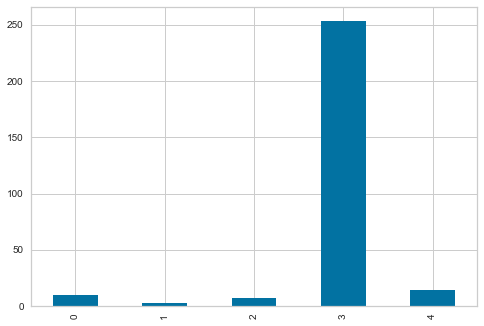

In [112]:
result_data['Count'].plot(kind='bar')
# ski_merged['cluster labels'].value_counts().plot(kind='bar')

## 6. Discussion

Given the different venues included in each cluster, I have named them based on domain knowledge of ski resorts. 

The different types of resorts are as follows:

**Day Resorts**
All of these boast restaurants, lakes or zoos. They are most likely day-use ski resorts.

**Geographic** 
These resorts are all located close by, and therefore have the same amenities. These are geographically similar.

**Outdoor Resorts**
These resorts are most outdoor-focused, with campgrounds, trails and zoos being the most frequent venues.

**Day Resorts**
All of these boast restaurants, lakes or liquor stores. They are most likely day-use ski resorts.

**Vacation Resorts** 
This is the majority of resorts. They have lots of amenities close by, with the majority boasting coffee shops, grocery stores and hotels. These would be classed as the vacation resorts. People choose to come here for leisure and longer amounts of time.

**Local Resorts**
It seems like these ski areas are located in industrial areas. They are probably unlikely to host tourists, due to the lack of amenities. These will be local resorts.


The majority of resorts are included in the Vacation Resort cluster, over 250 of the total number of resorts. 

## 7. Conclusion

In this study, I analysed the different types of ski resort in Canada, based on the venue and geographic data collected. I identified locations, venues, venue categories and the characteristics of each cluster. I built a K-means clustering model, to predict the type of group in which a resort might be located. This model can be useful in helping resort managers and marketing teams decide on the activities and amenities that are available, as well as the potential target market to whom they could be advertising. For example, it could help managers identify that their resort is similar to others who offer their customers a coffee shop, and prompt them to open one too. Or, marketing teams could understand their audience would be families looking for long-term stays, and advertise focused on these specific groups. 

To continue the analysis, I would like to further cut down the data and perhaps focus solely on the downhill resorts, and try other types of clustering algorithms to see if the results differ. 